In [16]:
import sys
sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
# sys.path.append('/workspaces/eth-capstone-treewater-deficit/src')
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import StandardScaler
from treewater.utils import *

In this notebook we set 7 day horizon and to be included in the model

In [17]:
import importlib
import treewater.utils as utils
importlib.reload(utils)

# check presence
print(hasattr(utils, "build_autoregressive_training_data_fast_LSTM_scheduled"))
print(hasattr(utils, "teacher_forcing_prob"))
print(hasattr(utils, "cross_validation_LSTM_FT"))
print(hasattr(utils, "teacher_forcing_prob_stepwise"))
print(hasattr(utils, "cross_validation_LSTM_AR"))
print(hasattr(utils, "clip_and_inverse_log2_transform"))

True
True
True
True
True
True


In [7]:
# set global random seed
seed = 66666
tf.random.set_seed(
    seed
)

In [8]:
# # At top of notebook
# %load_ext autoreload
# %autoreload 2

# from treewater.utils import *

In [4]:
derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
# data_dir = "/workspaces/eth-capstone-treewater-deficit/data/tstoy04"
# derived_path = "/workspaces/eth-capstone-treewater-deficit/data"

In [5]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [6]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [9]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [11]:
# twd_tree_series_sites

In [10]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [11]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [12]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

(array([8368., 2837., 2769., 2630., 2114., 1456.,  740.,  628.,  271.,
         107.]),
 array([0.        , 0.27301828, 0.54603655, 0.81905483, 1.0920731 ,
        1.36509138, 1.63810966, 1.91112793, 2.18414621, 2.45716448,
        2.73018276]),
 <BarContainer object of 10 artists>)

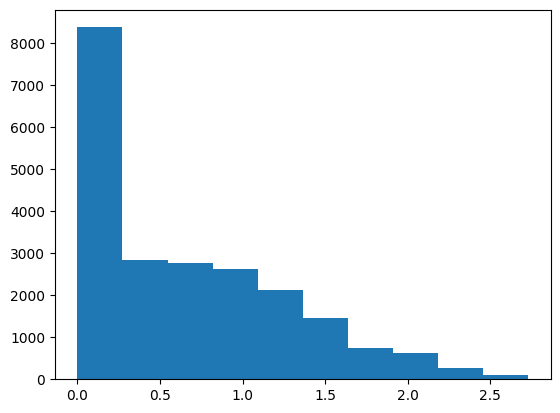

In [13]:
plt.hist(df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [15]:
# Configure features
config = FeatureConfig()
lag_n =7 # use 7 and smaller model size 
label_window_size = 7

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = create_training_test_set_optimized(
    df_series_features_log2,
    feature_window_size=lag_n, # optional
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)





2026-01-17 12:15:54.952116: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### build LSTM
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [18]:

batch_size = 64
lag_n = 7
label_window_size = 7

### Autoregressive
- reduce hidden space size to prevent overfitting

In [ ]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(
    train_df_at, n_splits=4, feature_window_size=lag_n,  config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        label_window_size = label_window_size,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        label_window_size = label_window_size,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    

TypeError: build_ds_from_get_dataset_LSTM() got an unexpected keyword argument 'label_window_size'

In [23]:
# dynamic input
def build_autoregressive_model_lstm( train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, hidden_unit = 16):
     # we don't actually need the input features but rather the shape information
    timesteps = lag_n
    n_features = train_X_ts_at.shape[2] # include TWD + other variables

    dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")
    x_dyn = tf_keras.layers.LSTM(hidden_unit, return_sequences=False)(dyn_in)
    x_dyn = tf_keras.layers.Dense(hidden_unit, activation="relu")(x_dyn)

    # current day other features
    n_static = train_day_feat_X.shape[1]
    static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
    x_static = tf_keras.layers.Dense(4, 
                                     activation="relu",
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                     )(static_in)

    # static input
    n_current = train_static_X_ts.shape[1]
    curr_in = tf_keras.Input(shape=(n_current,), name="static")
    x_curr = tf_keras.layers.Dense(4, 
                                   activation="relu",
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                   )(curr_in)


    combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
    x = tf_keras.layers.Dense(16, activation="relu")(combined)
    out = tf_keras.layers.Dense(1, activation = "linear")(x)


    model_at = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
    )

    model_at.compile(
        optimizer=tf_keras.optimizers.Adam(learning_rate=1e-4*5),
        loss="mae",
        metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
    )
    return model_at

In [24]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    



In [25]:
# create two models with different hidden units 

model_fold1 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = 16)
maes_cv_at, rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = cross_validation_LSTM(
    model_fold1,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size
)

model_fold2 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at , lag_n, hidden_unit = 32)
maes_cv_at2, rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2, y_preds_cv_at2, y_trues_cv_at2, historys_cv_at2  = cross_validation_LSTM(
    model_fold2,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size
)


Training fold 1/4
Epoch 1/40


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5236 - mae: 0.5147 - rmse: 0.6750 - val_loss: 0.4620 - val_mae: 0.4531 - val_rmse: 0.5696
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4699 - mae: 0.4611 - rmse: 0.5987 - val_loss: 0.4450 - val_mae: 0.4363 - val_rmse: 0.5575
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4197 - mae: 0.4111 - rmse: 0.5301 - val_loss: 0.4330 - val_mae: 0.4245 - val_rmse: 0.5533
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3646 - mae: 0.3562 - rmse: 0.4547 - val_loss: 0.4217 - val_mae: 0.4134 - val_rmse: 0.5479
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3124 - mae: 0.3042 - rmse: 0.3882 - val_loss: 0.4131 - val_mae: 0.4050 - val_rmse: 0.5457
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2694 - mae: 0.2614 - rmse: 0.3401 - val_loss: 0.4088 - val_mae: 0.4008 - val_rmse: 0.5458
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2408 - mae: 0.2329 - rmse: 0.3098 - val_loss: 0.40

2026-01-01 12:18:02.496563: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 2/4
Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4844 - mae: 0.4756 - rmse: 0.6353 - val_loss: 0.5847 - val_mae: 0.5761 - val_rmse: 0.6739
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4339 - mae: 0.4255 - rmse: 0.5668 - val_loss: 0.5318 - val_mae: 0.5236 - val_rmse: 0.6167
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3922 - mae: 0.3841 - rmse: 0.5096 - val_loss: 0.4827 - val_mae: 0.4749 - val_rmse: 0.5645
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3422 - mae: 0.3345 - rmse: 0.4377 - val_loss: 0.4077 - val_mae: 0.4001 - val_rmse: 0.4864
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2775 - mae: 0.2700 - rmse: 0.3509 - val_loss: 0.3304 - val_mae: 0.3230 - val_rmse: 0.4082
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2356 - mae: 0.2283 - rmse: 0.3022 - val_loss: 0.2975 - val_mae: 0.2904 - val_rmse: 0.3739
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2127 - mae: 0.2056 - r

2026-01-01 12:18:38.340350: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 3/4
Epoch 1/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4870 - mae: 0.4784 - rmse: 0.6248 - val_loss: 0.4079 - val_mae: 0.3998 - val_rmse: 0.5137
Epoch 2/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3751 - mae: 0.3671 - rmse: 0.4851 - val_loss: 0.3093 - val_mae: 0.3016 - val_rmse: 0.3954
Epoch 3/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2699 - mae: 0.2623 - rmse: 0.3487 - val_loss: 0.2737 - val_mae: 0.2663 - val_rmse: 0.3455
Epoch 4/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2158 - mae: 0.2085 - rmse: 0.2855 - val_loss: 0.2172 - val_mae: 0.2100 - val_rmse: 0.2775
Epoch 5/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1895 - mae: 0.1825 - rmse: 0.2566 - val_loss: 0.1907 - val_mae: 0.1838 - val_rmse: 0.2497
Epoch 6/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1754 - mae: 0.1686 - rmse: 0.2419 - val_loss: 0.1727 - val_mae: 0.1661 - val_rmse: 0.2313
Epoch 7/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1653 - m

2026-01-01 12:20:10.369862: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 1/4
Epoch 1/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.5455 - mae: 0.5343 - rmse: 0.7123 - val_loss: 0.4945 - val_mae: 0.4835 - val_rmse: 0.6444
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4041 - mae: 0.3931 - rmse: 0.5246 - val_loss: 0.4696 - val_mae: 0.4588 - val_rmse: 0.6261
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3233 - mae: 0.3125 - rmse: 0.4109 - val_loss: 0.4177 - val_mae: 0.4070 - val_rmse: 0.5533
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2660 - mae: 0.2555 - rmse: 0.3424 - val_loss: 0.3264 - val_mae: 0.3160 - val_rmse: 0.4237
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2272 - mae: 0.2169 - rmse: 0.2956 - val_loss: 0.3005 - val_mae: 0.2903 - val_rmse: 0.3922
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2028 - mae: 0.1927 - rmse: 0.2655 - val_loss: 0.3085 - val_mae: 0.2986 - val_rmse: 0.4058
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1906 - mae: 0.1807 - 

2026-01-01 12:22:55.973703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2
rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at

([0.6852020748775091,
  0.48342802096721776,
  0.3710774132975041,
  0.42198014225599273],
 [0.35039058327674866,
  0.23699454963207245,
  0.15889059007167816,
  0.17848621308803558],
 [0.6002489328384399,
  0.8524519801139832,
  0.9200190305709839,
  0.9199267625808716],
 [-0.5214400802178774,
  0.3973847625914808,
  0.5249346783305018,
  0.5490165721950241])

In [27]:
print(rmses_cv_at)
rmses_cv_at2

[0.6852020748775091, 0.48342802096721776, 0.3710774132975041, 0.42198014225599273]


[0.546936658691852,
 0.45653385687253456,
 0.3418825151635203,
 0.4609746609843628]

[Text(1, 0, 'hidden size =16'), Text(2, 0, 'hidden size =32')]

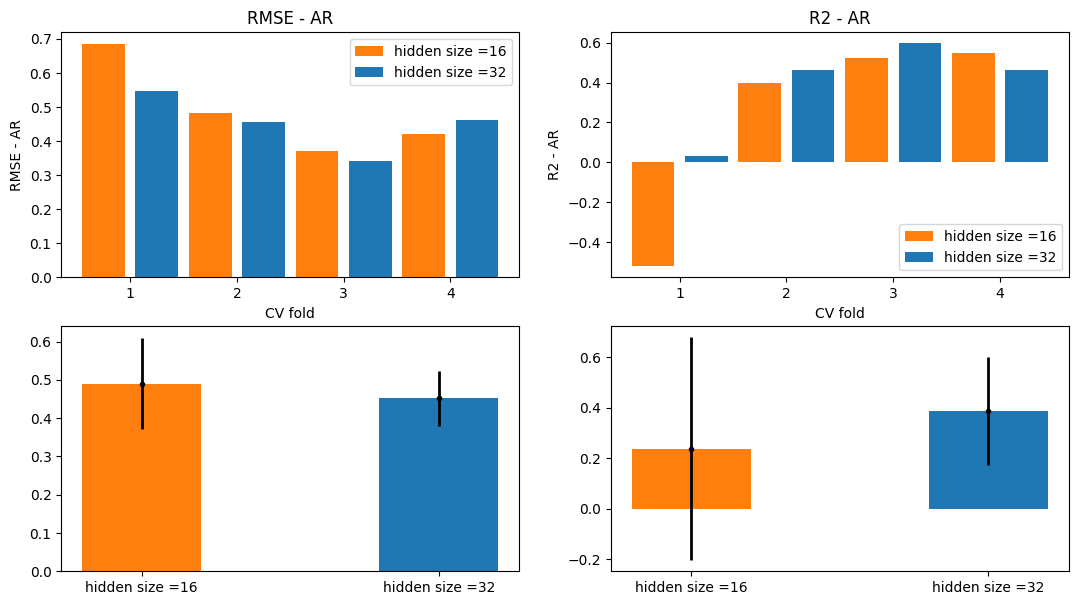

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 7))

ax1.bar(np.arange(0.75,4.75, 1), rmses_cv_at, color='tab:orange', width = 0.4)
ax1.bar(np.arange(1.25,5.25,1),rmses_cv_at2, color = "tab:blue", width = 0.4)

ax1.set_xticks(range(1,5))
ax1.legend(['hidden size =16', 'hidden size =32'])
ax1.set_ylabel('RMSE - AR')
ax1.set_xlabel("CV fold")
ax1.set_title("RMSE - AR")
# rmses_cv_at


ax2.bar(np.arange(0.75, 4.75, 1), r2s_cv_at, color='tab:orange', width = 0.4)
ax2.bar(np.arange(1.25,5.25,1),r2s_cv_at2, color = "tab:blue", width = 0.4)
ax2.set_xticks(range(1,5))
ax2.legend(['hidden size =16', 'hidden size =32'])
ax2.set_ylabel('R2 - AR')
ax2.set_xlabel("CV fold")
ax2.set_title("R2 - AR")   


ax3.bar([1,2],  [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax3.errorbar(x = [1,2], y = [np.mean(rmses_cv_at), np.mean(rmses_cv_at2)], 
             yerr=[np.std(rmses_cv_at), np.std(rmses_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax3.set_xticks([1,2])
ax3.set_xticklabels(['hidden size =16', 'hidden size =32'])


ax4.bar([1,2],  [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)],
       color=['tab:orange', 'tab:blue'], width = 0.4)
ax4.errorbar(x = [1,2], y = [np.mean(r2s_cv_at), np.mean(r2s_cv_at2)], 
             yerr=[np.std(r2s_cv_at), np.std(r2s_cv_at2)],
             fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1)
ax4.set_xticks([1,2])
ax4.set_xticklabels(['hidden size =16', 'hidden size =32'])
             

- performance appears more stable when hidden space dimension is 32 

In [39]:
hidden_unit_size = 32

In [40]:
model_at = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = hidden_unit_size)
history_at = model_at.fit(
    train_ds_at,
    epochs=50,
    validation_data=val_ds_at,
)


Epoch 1/50


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2689 - mae: 0.2586 - rmse: 0.3773 - val_loss: 0.1649 - val_mae: 0.1553 - val_rmse: 0.2222
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1590 - mae: 0.1499 - rmse: 0.2258 - val_loss: 0.1344 - val_mae: 0.1259 - val_rmse: 0.1911
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1360 - mae: 0.1280 - rmse: 0.2024 - val_loss: 0.1220 - val_mae: 0.1144 - val_rmse: 0.1755
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1257 - mae: 0.1185 - rmse: 0.1924 - val_loss: 0.1166 - val_mae: 0.1097 - val_rmse: 0.1707
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1172 - mae: 0.1106 - rmse: 0.1846 - val_loss: 0.1089 - val_mae: 0.1027 - val_rmse: 0.1658
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1117 - mae: 0.1058 - rmse: 0.1795 - val_loss: 0.1028 - val_mae: 0.0971 - val_rmse: 0.1618
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1073 - mae: 0.1018 - rmse: 0.1757 - v

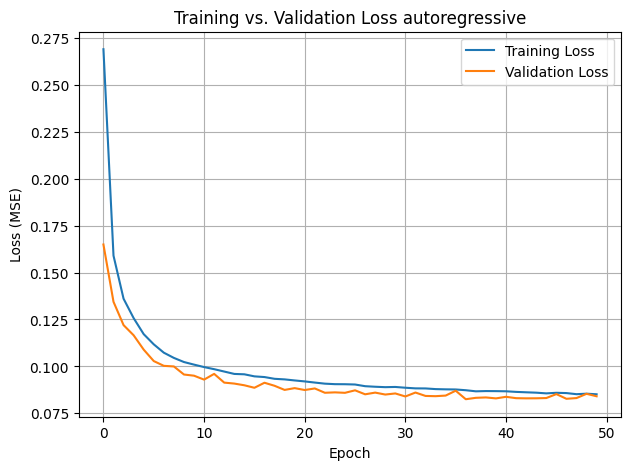

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
rmse: 0.182948, r2: 0.945363 


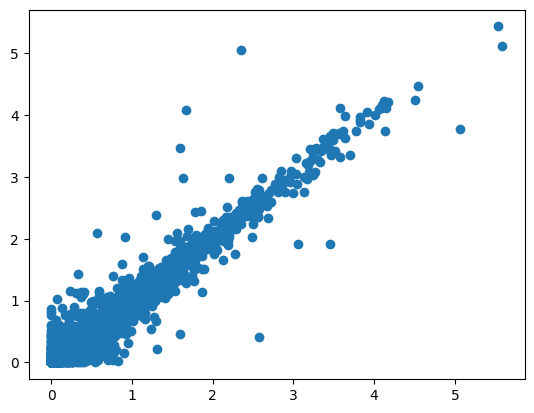

In [41]:


# Extract loss values
train_loss_at= history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day_at= model_at.predict(val_ds_at)# show first few predictions

rmse_1day_at = root_mean_squared_error(clip_and_inverse_log2_transform(y_pred_val_1day_at), clip_and_inverse_log2_transform(val_y_at))
r2_1day_at = r2_score(clip_and_inverse_log2_transform(val_y_at), clip_and_inverse_log2_transform(y_pred_val_1day_at))
print(f'rmse: {rmse_1day_at:3f}, r2: {r2_1day_at:3f} ')
plt.scatter(clip_and_inverse_log2_transform(val_y_at), clip_and_inverse_log2_transform(y_pred_val_1day_at))

In [65]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at, y_val_at = compute_recursive_predictions_fast_LSTM(model_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [66]:
r2_at = r2_score(clip_and_inverse_log2_transform(y_val_at), clip_and_inverse_log2_transform(y_pred_val_at))
rmse_at = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_at), clip_and_inverse_log2_transform(y_pred_val_at))

print(f"r2: {r2_at}\n rmse: {rmse_at}")

r2: 0.6802166528134933
 rmse: 0.4471958190586472


add cross-validation

In [49]:
# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=hidden_unit_size,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# fine tune the model within CV

maes_cv_at_finetune, rmses_cv_at_finetune, rmses_cv_1d_at_finetune, r2s_cv_1d_at_finetune, \
r2s_cv_at_finetune, y_preds_cv_at_finetune, y_trues_cv_at_finetune, historys_cv_at_finetune = cross_validation_LSTM_FT(
    model_ar,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=50,
    batch_size = batch_size
)



Training fold 1/4
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2173 - mae: 0.2166 - rmse: 0.3143 - val_loss: 0.1486 - val_mae: 0.1479 - val_rmse: 0.1980
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2077 - mae: 0.2070 - rmse: 0.2999 - val_loss: 0.1490 - val_mae: 0.1483 - val_rmse: 0.2017
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1993 - mae: 0.1986 - rmse: 0.2928 - val_loss: 0.1477 - val_mae: 0.1471 - val_rmse: 0.2042
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1966 - mae: 0.1959 - rmse: 0.2904 - val_loss: 0.1462 - val_mae: 0.1456 - val_rmse: 0.2040
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1926 - mae: 0.1919 - rmse: 0.2868 - val_loss: 0.1424 - val_mae: 0.1418 - val_rmse: 0.2006
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1908 - mae: 0.1901 - rmse: 0.2843 - val_loss: 0.1406 - val_mae: 0.1399 - val_rmse: 0.1993
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1887 - mae: 0.1880 - 

In [50]:
X_dyn_ar, X_day_ar, X_static_ar, y_ar = build_autoregressive_training_data_fast_LSTM(
    model=model_at,
    df=train_df_at,
    feature_window_size=lag_n,
    label_window_size=1,
    shift=1,
    config=config,
    batch_size=64,
)

ds_ar = tf.data.Dataset.from_tensor_slices(
    ((X_dyn_ar, X_day_ar, X_static_ar), y_ar)
).batch(64).prefetch(tf.data.AUTOTUNE)

In [51]:
# train final model on the full training set with AR-corrupted data
E2 = 50

# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=hidden_unit_size,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# now fine-tune on AR-corrupted dataset
model_ar.fit(
    ds_ar,
    epochs=E2,
    validation_data=val_ds_at
)


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2119 - mae: 0.2113 - rmse: 0.3215 - val_loss: 0.1188 - val_mae: 0.1181 - val_rmse: 0.1715
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2073 - mae: 0.2067 - rmse: 0.3162 - val_loss: 0.1306 - val_mae: 0.1300 - val_rmse: 0.1852
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2066 - mae: 0.2059 - rmse: 0.3140 - val_loss: 0.1401 - val_mae: 0.1394 - val_rmse: 0.1961
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2054 - mae: 0.2047 - rmse: 0.3120 - val_loss: 0.1472 - val_mae: 0.1466 - val_rmse: 0.2038
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2043 - mae: 0.2037 - rmse: 0.3102 - val_loss: 0.1524 - val_mae: 0.1518 - val_rmse: 0.2099
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2039 - mae: 0.2032 - rmse: 0.3090 - val_loss: 0.1577 - val_mae: 0.1570 - val_rmse: 0.2162
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2033 - mae: 0.2026 - rmse:

In [52]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_FT, y_val_at_FT = compute_recursive_predictions_fast_LSTM(model_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [53]:
r2_FT = r2_score(clip_and_inverse_log2_transform(y_val_at_FT), clip_and_inverse_log2_transform(y_pred_val_at_FT))
rmse_FT = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_at_FT), clip_and_inverse_log2_transform(y_pred_val_at_FT))

print(f"r2: {r2_FT}\n rmse: {rmse_FT}")

r2: 0.18410576705114268
 rmse: 0.7143100233380566


### scheduled sampling - train model

cross validation - implement cross validation

In [54]:
num_epochs = 45

# init model with same architecture
model_at_ar_cv = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=hidden_unit_size,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar_cv.set_weights(model_at.get_weights())

maes_cv_at_ar, rmses_cv_at_ar, rmses_cv_1d_at_ar, r2s_cv_1d_at_ar, \
r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar, historys_cv_at_ar = cross_validation_LSTM_AR(
    model_at_ar_cv,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=num_epochs,
    batch_size = batch_size,
    p_min = 0.1,
    warmup_epochs=3,
    frac_decay=0.9,
    slow_decay=True)




Training fold 1/4
Epoch 1/45 - loss: 0.0855 - rmse: 0.1489 - val_loss: 0.1061 - val_rmse: 0.1647 - p_tf: 1.000


2026-01-01 12:35:27.706409: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/45 - loss: 0.0832 - rmse: 0.1464 - val_loss: 0.1096 - val_rmse: 0.1689 - p_tf: 1.000
Epoch 3/45 - loss: 0.0824 - rmse: 0.1453 - val_loss: 0.1072 - val_rmse: 0.1653 - p_tf: 1.000
Epoch 4/45 - loss: 0.0861 - rmse: 0.1526 - val_loss: 0.1076 - val_rmse: 0.1661 - p_tf: 0.871
Epoch 5/45 - loss: 0.0853 - rmse: 0.1523 - val_loss: 0.1096 - val_rmse: 0.1679 - p_tf: 0.871
Epoch 6/45 - loss: 0.0858 - rmse: 0.1517 - val_loss: 0.1097 - val_rmse: 0.1669 - p_tf: 0.871
Epoch 7/45 - loss: 0.0856 - rmse: 0.1516 - val_loss: 0.1075 - val_rmse: 0.1673 - p_tf: 0.871
Epoch 8/45 - loss: 0.0855 - rmse: 0.1512 - val_loss: 0.1122 - val_rmse: 0.1706 - p_tf: 0.871
Epoch 9/45 - loss: 0.0901 - rmse: 0.1561 - val_loss: 0.1125 - val_rmse: 0.1716 - p_tf: 0.743


2026-01-01 12:38:01.824557: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/45 - loss: 0.0901 - rmse: 0.1556 - val_loss: 0.1101 - val_rmse: 0.1696 - p_tf: 0.743
Epoch 11/45 - loss: 0.0884 - rmse: 0.1540 - val_loss: 0.1116 - val_rmse: 0.1708 - p_tf: 0.743
Epoch 12/45 - loss: 0.0879 - rmse: 0.1531 - val_loss: 0.1146 - val_rmse: 0.1714 - p_tf: 0.743
Epoch 13/45 - loss: 0.0875 - rmse: 0.1526 - val_loss: 0.1121 - val_rmse: 0.1710 - p_tf: 0.743
Epoch 14/45 - loss: 0.0937 - rmse: 0.1592 - val_loss: 0.1080 - val_rmse: 0.1659 - p_tf: 0.614
Epoch 15/45 - loss: 0.0926 - rmse: 0.1577 - val_loss: 0.1122 - val_rmse: 0.1700 - p_tf: 0.614
Epoch 16/45 - loss: 0.0929 - rmse: 0.1580 - val_loss: 0.1156 - val_rmse: 0.1731 - p_tf: 0.614
Epoch 17/45 - loss: 0.0927 - rmse: 0.1588 - val_loss: 0.1112 - val_rmse: 0.1711 - p_tf: 0.614
Epoch 18/45 - loss: 0.0916 - rmse: 0.1570 - val_loss: 0.1089 - val_rmse: 0.1662 - p_tf: 0.614
Epoch 19/45 - loss: 0.1019 - rmse: 0.1702 - val_loss: 0.1189 - val_rmse: 0.1773 - p_tf: 0.486
Epoch 20/45 - loss: 0.1057 - rmse: 0.1746 - val_loss: 0.1197

2026-01-01 12:43:17.054396: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26/45 - loss: 0.1118 - rmse: 0.1847 - val_loss: 0.1130 - val_rmse: 0.1711 - p_tf: 0.357
Epoch 27/45 - loss: 0.1139 - rmse: 0.1843 - val_loss: 0.1122 - val_rmse: 0.1703 - p_tf: 0.357
Epoch 28/45 - loss: 0.1143 - rmse: 0.1886 - val_loss: 0.1220 - val_rmse: 0.1787 - p_tf: 0.357
Epoch 29/45 - loss: 0.1368 - rmse: 0.2169 - val_loss: 0.1079 - val_rmse: 0.1643 - p_tf: 0.229
Epoch 30/45 - loss: 0.1516 - rmse: 0.2357 - val_loss: 0.1316 - val_rmse: 0.1875 - p_tf: 0.229
Epoch 31/45 - loss: 0.1848 - rmse: 0.2796 - val_loss: 0.1222 - val_rmse: 0.1784 - p_tf: 0.229
Epoch 32/45 - loss: 0.1885 - rmse: 0.2795 - val_loss: 0.1351 - val_rmse: 0.1929 - p_tf: 0.229
Epoch 33/45 - loss: 0.2429 - rmse: 0.3483 - val_loss: 0.1576 - val_rmse: 0.2239 - p_tf: 0.229
Epoch 34/45 - loss: 0.2843 - rmse: 0.3983 - val_loss: 0.1623 - val_rmse: 0.2285 - p_tf: 0.100
Epoch 35/45 - loss: 0.3298 - rmse: 0.4609 - val_loss: 0.2600 - val_rmse: 0.3665 - p_tf: 0.100
Epoch 36/45 - loss: 0.3522 - rmse: 0.5080 - val_loss: 0.1667

2026-01-01 12:55:06.234711: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13/45 - loss: 0.0923 - rmse: 0.1586 - val_loss: 0.1062 - val_rmse: 0.1932 - p_tf: 0.743
Epoch 14/45 - loss: 0.0977 - rmse: 0.1662 - val_loss: 0.1122 - val_rmse: 0.1970 - p_tf: 0.614
Epoch 15/45 - loss: 0.0977 - rmse: 0.1669 - val_loss: 0.1068 - val_rmse: 0.1930 - p_tf: 0.614
Epoch 16/45 - loss: 0.0980 - rmse: 0.1662 - val_loss: 0.1068 - val_rmse: 0.1949 - p_tf: 0.614
Epoch 17/45 - loss: 0.0984 - rmse: 0.1674 - val_loss: 0.1111 - val_rmse: 0.1961 - p_tf: 0.614
Epoch 18/45 - loss: 0.0995 - rmse: 0.1669 - val_loss: 0.1116 - val_rmse: 0.1964 - p_tf: 0.614
Epoch 19/45 - loss: 0.1072 - rmse: 0.1784 - val_loss: 0.1125 - val_rmse: 0.1951 - p_tf: 0.486
Epoch 20/45 - loss: 0.1068 - rmse: 0.1757 - val_loss: 0.1247 - val_rmse: 0.2063 - p_tf: 0.486
Epoch 21/45 - loss: 0.1068 - rmse: 0.1768 - val_loss: 0.1113 - val_rmse: 0.1955 - p_tf: 0.486
Epoch 22/45 - loss: 0.1092 - rmse: 0.1814 - val_loss: 0.1121 - val_rmse: 0.1974 - p_tf: 0.486
Epoch 23/45 - loss: 0.1067 - rmse: 0.1756 - val_loss: 0.1199

2026-01-01 13:23:15.309863: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31/45 - loss: 0.1747 - rmse: 0.2673 - val_loss: 0.1061 - val_rmse: 0.1671 - p_tf: 0.229
Epoch 32/45 - loss: 0.1831 - rmse: 0.2779 - val_loss: 0.1234 - val_rmse: 0.1798 - p_tf: 0.229
Epoch 33/45 - loss: 0.1828 - rmse: 0.2736 - val_loss: 0.1314 - val_rmse: 0.1974 - p_tf: 0.229
Epoch 34/45 - loss: 0.2268 - rmse: 0.3291 - val_loss: 0.1743 - val_rmse: 0.2510 - p_tf: 0.100
Epoch 35/45 - loss: 0.2354 - rmse: 0.3364 - val_loss: 0.2074 - val_rmse: 0.3024 - p_tf: 0.100
Epoch 36/45 - loss: 0.2675 - rmse: 0.3839 - val_loss: 0.2354 - val_rmse: 0.3392 - p_tf: 0.100
Epoch 37/45 - loss: 0.2591 - rmse: 0.3651 - val_loss: 0.2252 - val_rmse: 0.3247 - p_tf: 0.100
Epoch 38/45 - loss: 0.2703 - rmse: 0.3831 - val_loss: 0.2338 - val_rmse: 0.3317 - p_tf: 0.100
Epoch 39/45 - loss: 0.2382 - rmse: 0.3413 - val_loss: 0.2134 - val_rmse: 0.3113 - p_tf: 0.100
Epoch 40/45 - loss: 0.2508 - rmse: 0.3579 - val_loss: 0.2155 - val_rmse: 0.3059 - p_tf: 0.100
Epoch 41/45 - loss: 0.2272 - rmse: 0.3239 - val_loss: 0.2005

- more epochs, decay slower, stepwise training 
- hidden size 16, shorter window

In [ ]:
# now do scheduled sampling training on the full training set
num_epochs = 120

history_ar_at = {
"loss": [],
"rmse": [],
"val_loss": [],
"val_rmse": [],
"p_tf": []
}


# init model with same architecture
model_at_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=hidden_unit_size,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar.set_weights(model_at.get_weights())



for epoch in range(num_epochs):
        # train model with teacher forcing for the first epoch 
    p_tf = teacher_forcing_prob_stepwise(epoch, num_epochs,epoch_per_step=15, step_size=0.1, p0=1.0, p_min=0.1, warmup_epochs=3, frac_decay=0.9)
    history_ar_at["p_tf"].append(p_tf)

    # rebuild AR / scheduled-sampling training data
    X_dyn_ar_at, X_day_ar_at, X_static_ar_at, y_ar_at = build_autoregressive_training_data_fast_LSTM_scheduled(
        model_at_ar,
        train_df_at,
        feature_window_size=lag_n,
        label_window_size=1,
        shift=1,
        config=config,
        batch_size=batch_size,
        teacher_forcing_prob=p_tf,
    )

    train_ds_at_decay = (
        tf.data.Dataset.from_tensor_slices(((X_dyn_ar_at, X_day_ar_at, X_static_ar_at), y_ar_at))
        .shuffle(len(X_dyn_ar_at))
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # one epoch of manual training
    epoch_loss = tf.keras.metrics.Mean()
    epoch_rmse = tf.keras.metrics.RootMeanSquaredError()

    for (x_dyn, x_day, x_stat), y in train_ds_at_decay:
        with tf.GradientTape() as tape:
            preds = model_at_ar([x_dyn, x_day, x_stat], training=True)
            loss = model_at_ar.compute_loss(x=None, y=y, y_pred=preds, sample_weight=None, training=True)

        grads = tape.gradient(loss, model_at_ar.trainable_variables)
        model_at_ar.optimizer.apply_gradients(zip(grads, model_at_ar.trainable_variables))      
        epoch_loss.update_state(loss)
        epoch_rmse.update_state(y, preds)

    # validation
    val_loss_metric = tf.keras.metrics.Mean()
    val_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    for (x_dyn_v, x_day_v, x_stat_v), y_v in val_ds_at:
        preds_v = model_at_ar([x_dyn_v, x_day_v, x_stat_v], training=False)
        v_loss = model_at_ar.compute_loss(x=None, y=y_v, y_pred=preds_v, sample_weight=None, training=False)
        val_loss_metric.update_state(v_loss)
        val_rmse_metric.update_state(y_v, preds_v)

    history_ar_at["loss"].append(epoch_loss.result().numpy())
    history_ar_at["rmse"].append(epoch_rmse.result().numpy())
    history_ar_at["val_loss"].append(val_loss_metric.result().numpy())
    history_ar_at["val_rmse"].append(val_rmse_metric.result().numpy())
    history_ar_at["p_tf"].append(p_tf)

    print(
        f"Epoch {epoch+1}/{num_epochs} - "
        f"loss: {history_ar_at['loss'][-1]:.4f} - rmse: {history_ar_at['rmse'][-1]:.4f} - "
        f"val_loss: {history_ar_at['val_loss'][-1]:.4f} - val_rmse: {history_ar_at['val_rmse'][-1]:.4f} - "
        f"p_tf: {p_tf:.3f}"
    )

Epoch 1/120 - loss: 0.0849 - rmse: 0.1572 - val_loss: 0.0823 - val_rmse: 0.1426 - p_tf: 1.000
Epoch 2/120 - loss: 0.0848 - rmse: 0.1566 - val_loss: 0.0837 - val_rmse: 0.1453 - p_tf: 1.000
Epoch 3/120 - loss: 0.0845 - rmse: 0.1567 - val_loss: 0.0828 - val_rmse: 0.1430 - p_tf: 1.000
Epoch 4/120 - loss: 0.0898 - rmse: 0.1640 - val_loss: 0.0843 - val_rmse: 0.1435 - p_tf: 0.871
Epoch 5/120 - loss: 0.0907 - rmse: 0.1675 - val_loss: 0.0843 - val_rmse: 0.1442 - p_tf: 0.871
Epoch 6/120 - loss: 0.0909 - rmse: 0.1662 - val_loss: 0.0830 - val_rmse: 0.1446 - p_tf: 0.871
Epoch 7/120 - loss: 0.0901 - rmse: 0.1654 - val_loss: 0.0836 - val_rmse: 0.1447 - p_tf: 0.871
Epoch 8/120 - loss: 0.0898 - rmse: 0.1632 - val_loss: 0.0835 - val_rmse: 0.1432 - p_tf: 0.871
Epoch 9/120 - loss: 0.0896 - rmse: 0.1649 - val_loss: 0.0856 - val_rmse: 0.1446 - p_tf: 0.871
Epoch 10/120 - loss: 0.0894 - rmse: 0.1634 - val_loss: 0.0829 - val_rmse: 0.1433 - p_tf: 0.871
Epoch 11/120 - loss: 0.0901 - rmse: 0.1644 - val_loss: 0.08

2026-01-01 14:40:01.589515: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 68/120 - loss: 0.1217 - rmse: 0.2034 - val_loss: 0.0932 - val_rmse: 0.1491 - p_tf: 0.357
Epoch 69/120 - loss: 0.1209 - rmse: 0.2039 - val_loss: 0.0931 - val_rmse: 0.1462 - p_tf: 0.357
Epoch 70/120 - loss: 0.1193 - rmse: 0.1990 - val_loss: 0.0934 - val_rmse: 0.1508 - p_tf: 0.357
Epoch 71/120 - loss: 0.1215 - rmse: 0.2035 - val_loss: 0.0927 - val_rmse: 0.1458 - p_tf: 0.357
Epoch 72/120 - loss: 0.1206 - rmse: 0.1987 - val_loss: 0.0991 - val_rmse: 0.1555 - p_tf: 0.357
Epoch 73/120 - loss: 0.1253 - rmse: 0.2067 - val_loss: 0.0960 - val_rmse: 0.1501 - p_tf: 0.357
Epoch 74/120 - loss: 0.1241 - rmse: 0.2033 - val_loss: 0.0953 - val_rmse: 0.1512 - p_tf: 0.357
Epoch 75/120 - loss: 0.1194 - rmse: 0.1987 - val_loss: 0.0941 - val_rmse: 0.1496 - p_tf: 0.357
Epoch 76/120 - loss: 0.1191 - rmse: 0.1988 - val_loss: 0.0992 - val_rmse: 0.1541 - p_tf: 0.357
Epoch 77/120 - loss: 0.1214 - rmse: 0.2010 - val_loss: 0.0966 - val_rmse: 0.1543 - p_tf: 0.357
Epoch 78/120 - loss: 0.1237 - rmse: 0.2073 - val_l

maybe adjust loss function?

In [ ]:
# save training history
train_his_path = f"/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data/derived/training_history/history_ar_at_LSTM_scheduled_sampling_log.npy"
np.save(train_his_path, history_ar_at)

In [56]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_ar, y_val_at_ar= compute_recursive_predictions_fast_LSTM(model_at_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_at_ar = r2_score(clip_and_inverse_log2_transform(y_val_at_ar),clip_and_inverse_log2_transform(y_pred_val_at_ar))
rmse_at_ar = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_at_ar), clip_and_inverse_log2_transform(y_pred_val_at_ar))

print(f"r2: {r2_at_ar}\n rmse: {rmse_at_ar}")

r2: -1.033223056711222
 rmse: 1.1276188457191507


In [67]:
# plot performance together

df_model_performance = pd.DataFrame({
    "model" :['teacher_forcing (hidden=16)'] *4 + ['teacher_forcing (hidden=32)'] *4 + ['fine_tuned (hidden=32)'] *4 + ['scheduled_sampling (hidden=32)'] *4,    
    "cv_fold"  : [i for i in range(1, len(maes_cv_at_ar) + 1)] *4,
    "mae": maes_cv_at + maes_cv_at2 + maes_cv_at_finetune + maes_cv_at_ar,
    "rmse_recursive": rmses_cv_at + rmses_cv_at2 + rmses_cv_at_finetune + rmses_cv_at_ar,
    "rmse_1day": rmses_cv_1d_at + rmses_cv_1d_at2 + rmses_cv_1d_at_finetune + rmses_cv_1d_at_ar,
    "r2_1day" : r2s_cv_1d_at + r2s_cv_1d_at2 + r2s_cv_1d_at_finetune + r2s_cv_1d_at_ar,
    "r2_recursive": r2s_cv_at + r2s_cv_at2 + r2s_cv_at_finetune + r2s_cv_at_ar,
}
)

df_model_p_long = df_model_performance.melt(id_vars=["model", "cv_fold"], 
                                        value_vars=["mae", "rmse_recursive", "rmse_1day", "r2_1day", "r2_recursive"],
                                        var_name="metric",
                                        value_name="value"
                                        )

In [68]:
df_model_p_long.loc[df_model_p_long.metric == "r2_recursive",]

,model,cv_fold,metric,value
64,teacher_forcing (hidden=16),1,r2_recursive,-0.521440
65,teacher_forcing (hidden=16),2,r2_recursive,0.397385
66,teacher_forcing (hidden=16),3,r2_recursive,0.524935
67,teacher_forcing (hidden=16),4,r2_recursive,0.549017
68,teacher_forcing (hidden=32),1,r2_recursive,0.030626
69,teacher_forcing (hidden=32),2,r2_recursive,0.462569
70,teacher_forcing (hidden=32),3,r2_recursive,0.596747
71,teacher_forcing (hidden=32),4,r2_recursive,0.461816
72,fine_tuned (hidden=32),1,r2_recursive,-0.291047
73,fine_tuned (hidden=32),2,r2_recursive,0.439742


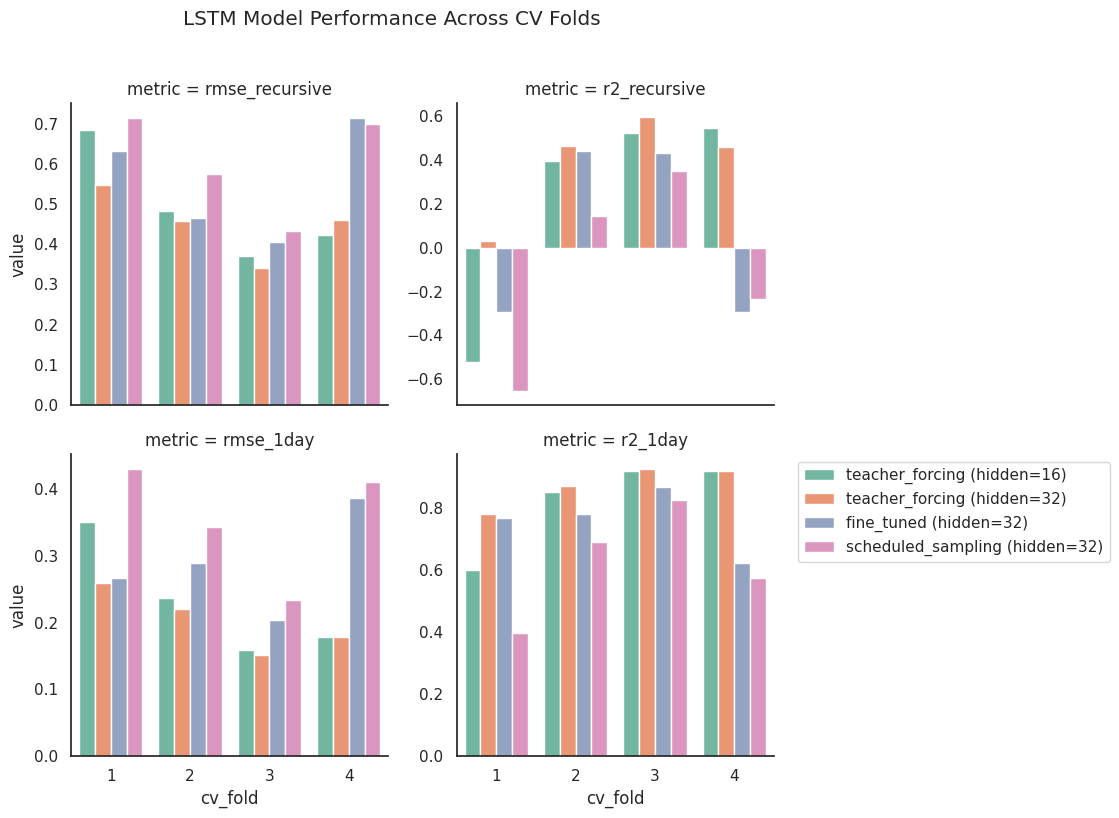

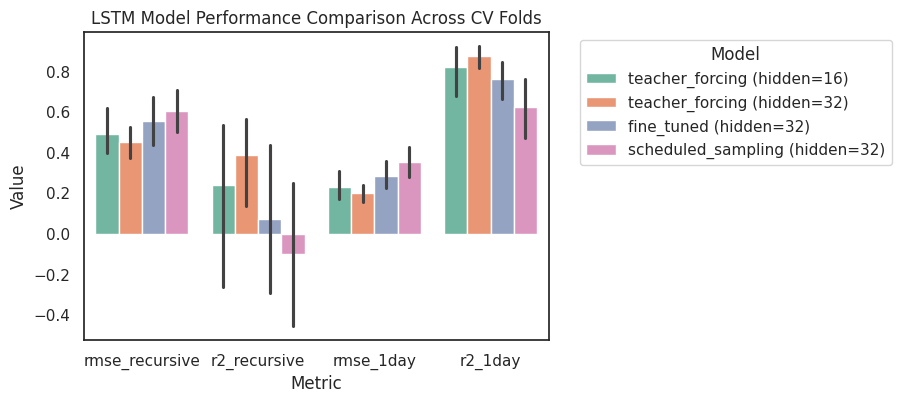

In [69]:
sns.set(style="white", font_scale=1,
        rc={"figure.figsize": (6, 4)})

metrics_plot = ['rmse_recursive', 'r2_recursive', 'rmse_1day', 'r2_1day']
df_p_plot = df_model_p_long.loc[df_model_p_long['metric'].isin(
metrics_plot
)]  
g = sns.FacetGrid(df_p_plot, col="metric", col_wrap = 2,
              col_order = metrics_plot,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="cv_fold",
    y="value",
    hue = 'model',
    palette = "Set2",
    legend = True,
)

g.figure.suptitle("LSTM Model Performance Across CV Folds", y=1.02)


plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

sns.barplot(df_p_plot, x="metric", y="value", hue="model", palette="Set2",
            order = metrics_plot)
plt.title("LSTM Model Performance Comparison Across CV Folds")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1))
plt.show()


/scratch/tmp.53027694.taoj/ipykernel_2829603/3687270685.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/scratch/tmp.53027694.taoj/ipykernel_2829603/3687270685.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.53027694.taoj/ipykernel_2829603/3687270685.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
/scratch/tmp.53027694.taoj/ipykernel_2829603/3687270685.py:34: UserWarning: color is redundantly defined by the 'color' k

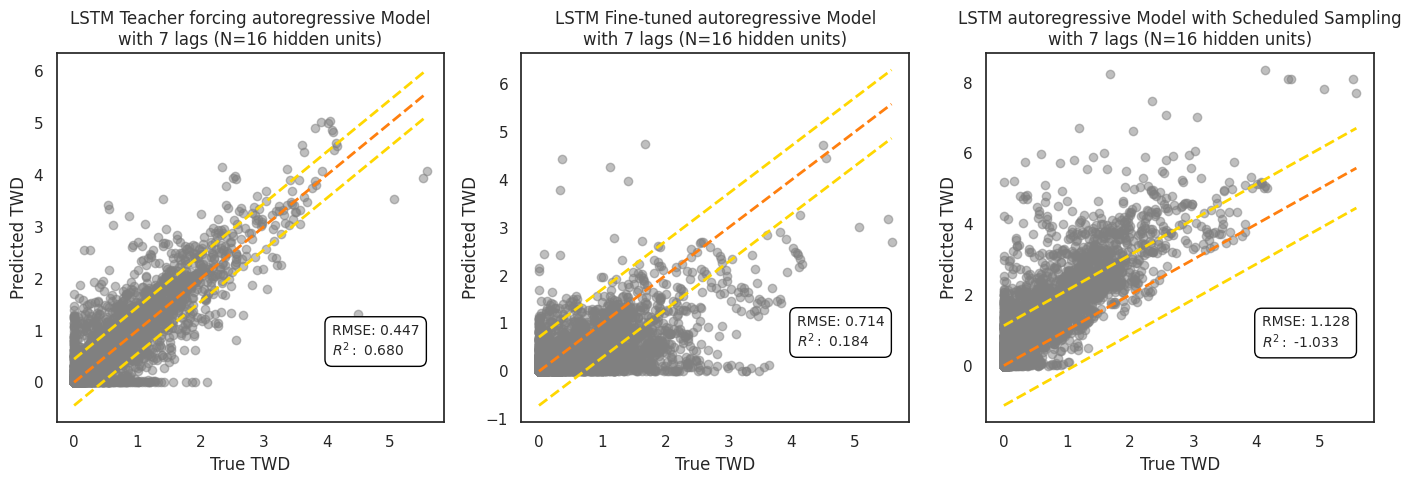

In [70]:
# Create figure with 3 subplots showing model final performance

def ensure_numpy(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()
    return np.asarray(x)
y_val_at = clip_and_inverse_log2_transform(ensure_numpy(y_val_at).reshape(-1))
y_pred_val_at = clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at).reshape(-1))
# val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14, 5))


# First subplot - Autoregressive Model Predictions hidden 32
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [y_val_at.min(), y_val_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"LSTM Teacher forcing autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax1.text(y_val_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# plot fine-tuned 
ax2.scatter(x =  clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)), y = clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)), color="grey", alpha=0.5)
ax2.set_xlabel("True TWD")
ax2.set_ylabel("Predicted TWD")
x_range = [clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).min(), clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()]
ax2.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax2.plot(x_range, [i+rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.plot(x_range, [i-rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.set_title(f"LSTM Fine-tuned autoregressive Model\nwith {lag_n} lags (N=16 hidden units)")
ax2.text(clip_and_inverse_log2_transform(ensure_numpy(y_val_at_FT).reshape(-1)).max()-1.5,clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_FT).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_FT:.3f}\n$R^2:$ {r2_FT:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))   


# plot scheduled sampling 
ax3.scatter(x = clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)), y = clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)), color="grey", alpha=0.5)
ax3.set_xlabel("True TWD")
ax3.set_ylabel("Predicted TWD")
x_range = [clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).min(), clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()]
ax3.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax3.plot(x_range, [i+rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.plot(x_range, [i-rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.set_title(f"LSTM autoregressive Model with Scheduled Sampling\nwith {lag_n} lags (N=16 hidden units)")
ax3.text(clip_and_inverse_log2_transform(ensure_numpy(y_val_at_ar).reshape(-1)).max()-1.5,clip_and_inverse_log2_transform(ensure_numpy(y_pred_val_at_ar).reshape(-1)).min()+0.5, 
         f"RMSE: {rmse_at_ar:.3f}\n$R^2:$ {r2_at_ar:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  

plt.tight_layout()
plt.show()



- timeseries prediction across timestep 

why the performance is so bad ..
- try the same on ridge regression?

to improve the model performance
- we can try to improve the LSTM architecture 
    -  added softplus - why it lowered the performance? 
    - play with the architecture and hyperparameter
- add also compute the correlation matrix of lagged features with twd
- should I create cross-validation function to choose the tune the model?
- how can i integrate autoregressive training?
- incorporate log value into traning 
- stack layers? 
- how to extrapolate if i use location and other static parameters in the future?
- perturbation to analyze feature importance